# Preliminary

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import dcs 
import pandas as pd
import numpy as np

In [3]:
dataset_name = 'metabric'
test_size = .2
random_seed = 40

# Dataset

In [4]:
dataset = dcs.datasets.get_dataset(dataset_name)
pipeline = dcs.pipelines.get_pipeline(dataset_name)

train_X, train_y, test_X, test_y = dcs.preprocessing.train_test_split_X_y(
    dataset,
    random_state=random_seed,
    test_size=test_size,
    stratify=dataset['has_event'],
    )

train_X_t = pipeline.fit_transform(train_X)
test_X_t = pipeline.transform(test_X)

display(train_X_t.head())

,marker_MKI67,marker_EGFR,marker_PGR,marker_ERBB2,hormone_treatment,radiotherapy,chemotherapy,er_positive,age
patient_id,,,,,,,,,
m-0673,-0.802284,0.073297,-0.061000,-0.193895,1.0,0.0,0.0,1.0,1.793404
m-0907,-0.669547,0.719618,-0.323504,-0.491732,1.0,1.0,1.0,1.0,-1.330031
m-0021,-0.303750,-0.917746,0.307967,-1.324030,1.0,1.0,1.0,1.0,-0.926909
m-0209,-0.759231,1.228561,-0.429770,-0.203864,0.0,1.0,0.0,1.0,0.413015
m-0626,-0.089504,0.096472,-0.638664,-0.499638,1.0,0.0,0.0,1.0,0.958910


# Models

In [5]:
train_max_months = int(np.ceil(train_y['event_days'].max() * 12 / 365))

epochs=100
drsa_epochs = epochs
kamran_epochs = epochs
dcs_epochs = epochs

In [6]:
predictions = {}

## CoxPH

In [7]:
cox = dcs.models.CoxPH()
cox.fit(train_X_t, train_y)
predictions['CoxPH'] = cox.predict(test_X_t)

## DeepSurv

In [8]:
deepsurv = dcs.models.DeepSurv()
deepsurv.fit(train_X_t, train_y)
predictions['DeepSurv'] = deepsurv.predict(test_X_t)

## CoxTime

In [9]:
coxtime = dcs.models.CoxTime()
coxtime.fit(train_X_t, train_y)
predictions['CoxTime'] = coxtime.predict(test_X_t)

/home/pfuhlert/src/discrete-calibrated-survival/.venv/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass copy=True, with_mean=True, with_std=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


## DRSA

In [10]:
drsa = dcs.models.Drsa(
    epochs=drsa_epochs, 
    use_early_stopping=True,
    early_stopping_patience=10,
    batch_size=50,
    output_grid_num_nodes=train_max_months,
    learning_rate = 1e-4,
    validation_size=.1
    )
drsa.fit(train_X_t, train_y)
predictions['DRSA'] = drsa.predict(test_X_t)

## Kamran

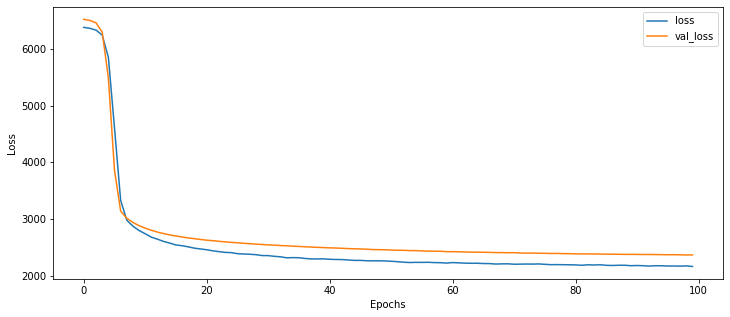

In [11]:
kamran = dcs.models.Kamran(
    epochs=kamran_epochs, 
    use_early_stopping=True,
    early_stopping_patience=10,
    batch_size=50,
    learning_rate = 1e-4,
    sigma=0.7,
    lambda_=1,
    output_grid_num_nodes=train_max_months,
    validation_size=.1)

kamran.fit(train_X_t, train_y)
kamran.plot_history()

predictions['Kamran'] = kamran.predict(test_X_t)

## DCS

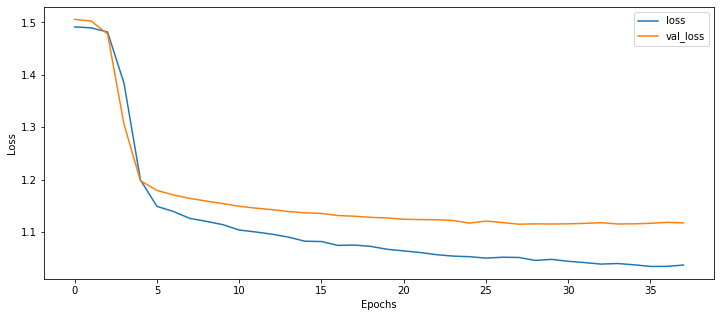

In [12]:
dcs_model = dcs.models.DcsModel(
    epochs=dcs_epochs, 
    use_early_stopping=True,
    early_stopping_patience=10,
    batch_size=50,
    learning_rate = 3e-4,
    sigma=0.7,
    lambda_=1,
    output_grid_type='quantile',
    output_grid_num_nodes=train_max_months,
    validation_size=.1)

dcs_model.fit(train_X_t, train_y)
dcs_model.plot_history()

predictions['DCS-Model'] = dcs_model.predict(test_X_t)

# Evaluation

## Qualitative Survival Curves

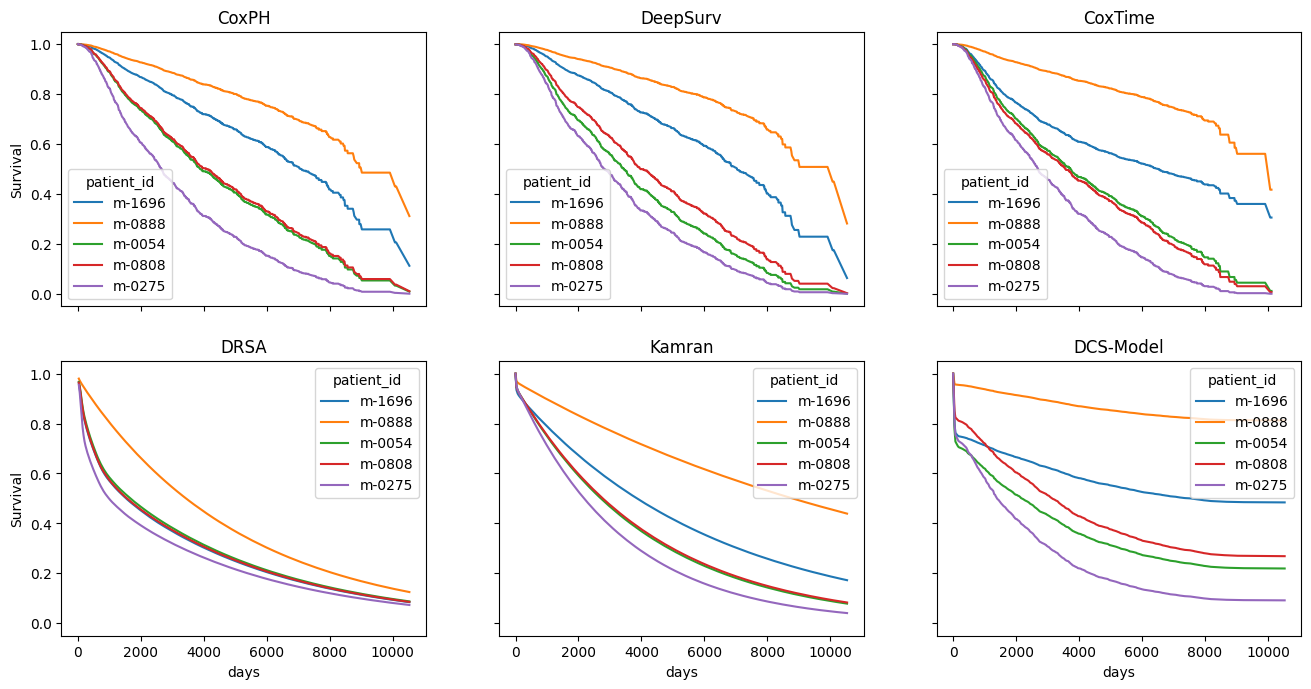

In [13]:
import matplotlib.pyplot as plt

sample_idx = test_X.sample(5).index

nrows=int(np.ceil(len(predictions)/3))

fig, axs = plt.subplots(
    figsize=(16, 4*nrows), dpi=100, 
    ncols=3, nrows=nrows,
    sharex=True, sharey=True)
axs = axs.reshape(-1)

for i, (model_name, prediction) in enumerate(predictions.items()):
    ax = axs[i]
    prediction.loc[sample_idx].T.plot(ax=ax)
    ax.set_title(model_name)
    ax.set_ylabel('Survival')
    ax.set_xlabel('days')


## Quantitative

In [14]:
results_df = pd.DataFrame()
for model_name, prediction in predictions.items():

    results_model = pd.Series({
        "c-index-td": dcs.evaluation.concordance_index_td(test_y, prediction),
        "cdauc": dcs.evaluation.cdauc(test_y, prediction),
        "ddc": dcs.evaluation.ddc(test_y, prediction),
    }, name=model_name)
    
    results_df = results_df.append(results_model)


display(results_df.T)

,CoxPH,DeepSurv,CoxTime,DRSA,Kamran,DCS-Model
c-index-td,0.656594,0.665680,0.658595,0.629147,0.654677,0.661158
cdauc,0.699691,0.654038,0.680524,0.620226,0.686190,0.686992
ddc,0.007362,0.009179,0.007496,0.307194,0.113364,0.154264
